
# PRISMA Preprocessing Diagnostics
Quick checks to ensure PRISMA L1 preprocessing (band ordering, CW/FWHM alignment, removed bands) is consistent with the radiance cube returned by `scripts.satellites.prisma_utils.prisma_read`.


In [8]:

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")

os.environ.setdefault("PYTHONPATH", str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# <<< Edit this path to point to your PRISMA L1 HE5 or ZIP >>>
PRISMA_L1_PATH = REPO_ROOT / "test_data" / "prisma" / "Northern_State_Sudan_20200401" / "20200401085313_20200401085318" / "PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip"

print(f"Notebook root: {NOTEBOOK_ROOT}Repo root: {REPO_ROOT}PRISMA L1: {PRISMA_L1_PATH}")


from scripts.satellites import prisma_utils
import tempfile

def ensure_resolved_prisma(path: Path, cache_dir: Path | None = None) -> Path:
    """Return a readable HE5 path, extracting ZIP next to it (or in cache_dir if provided)."""
    if path.suffix.lower() in {'.he5', '.h5', '.hdf5'}:
        return path
    if path.suffix.lower() == '.zip':
        target_dir = cache_dir if cache_dir is not None else path.parent
        target_dir.mkdir(parents=True, exist_ok=True)
        extracted = prisma_utils.extract_he5_from_zip(str(path), str(target_dir))
        if extracted is None:
            raise FileNotFoundError(f"No .he5 file found inside ZIP: {path}")
        return Path(extracted)
    raise ValueError(f"Unsupported PRISMA input format: {path}")


Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooksRepo root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygasPRISMA L1: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip


In [9]:

prisma_path = Path(PRISMA_L1_PATH)
if not prisma_path.exists():
    raise FileNotFoundError(f"PRISMA L1 path not found: {prisma_path}")

cache_dir = prisma_path.parent
resolved_path = ensure_resolved_prisma(prisma_path, cache_dir)
(
    cube,
    cw_matrix,
    fwhm_matrix,
    rgb_image,
    vnir_cube_bip,
    swir_cube_bip,
    latitude_vnir,
    longitude_vnir,
    latitude_swir,
    longitude_swir,
) = prisma_utils.prisma_read(str(resolved_path))

cw_band = np.nanmean(cw_matrix, axis=0)
fwhm_band = np.nanmean(fwhm_matrix, axis=0)

print("Radiance cube shape (rows, cols, bands):", cube.shape)
print("CW matrix shape:", cw_matrix.shape)
print("FWHM matrix shape:", fwhm_matrix.shape)
print("First/last CW (nm):", float(cw_band[0]), float(cw_band[-1]))
print("Resolved HE5:", resolved_path)


Radiance cube shape (rows, cols, bands): (1000, 1000, 234)
CW matrix shape: (1000, 234)
FWHM matrix shape: (1000, 234)
First/last CW (nm): 406.01348876953125 2496.7607421875
Resolved HE5: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.he5


CW ascending? False
Non-ascending indices: [62] 
Median CW step (nm): 9.3096923828125
Range CW step (nm): -33.5093994140625 → 11.792236328125


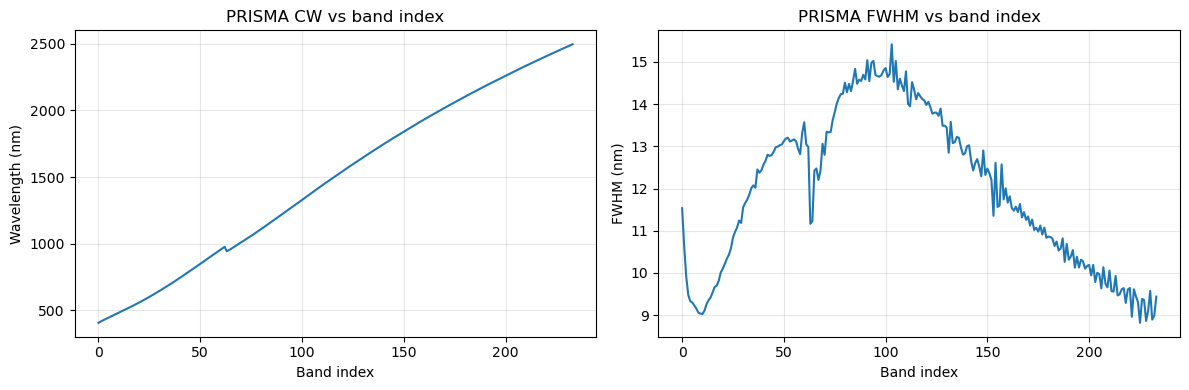

In [10]:

# Monotonicity check
ascending = np.all(np.diff(cw_band) > 0)
print("CW ascending?", ascending)
if not ascending:
    bad = np.where(np.diff(cw_band) <= 0)[0]
    print("Non-ascending indices:", bad[:20], "..." if bad.size > 20 else "")

# Band step statistics
cw_diff = np.diff(cw_band)
print("Median CW step (nm):", float(np.nanmedian(cw_diff)))
print("Range CW step (nm):", float(np.nanmin(cw_diff)), "→", float(np.nanmax(cw_diff)))

# Plot CW and FWHM
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(cw_band, label="CW")
ax[0].set_title("PRISMA CW vs band index")
ax[0].set_xlabel("Band index")
ax[0].set_ylabel("Wavelength (nm)")
ax[0].grid(alpha=0.3)
ax[1].plot(fwhm_band)
ax[1].set_title("PRISMA FWHM vs band index")
ax[1].set_xlabel("Band index")
ax[1].set_ylabel("FWHM (nm)")
ax[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()


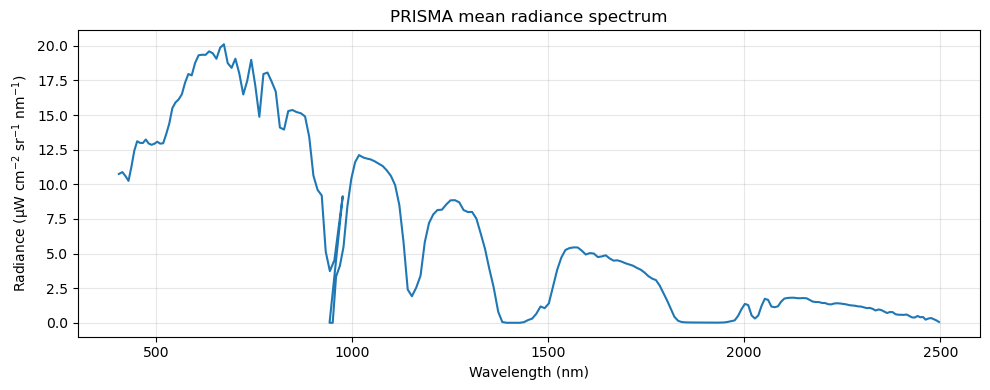

Nearest band to 940 nm -> index 63 (cw=943.09 nm)
Nearest band to 1140 nm -> index 83 (cw=1142.36 nm)
Nearest band to 1400 nm -> index 106 (cw=1394.92 nm)
Nearest band to 1900 nm -> index 156 (cw=1895.88 nm)
Nearest band to 2200 nm -> index 192 (cw=2198.86 nm)


In [11]:

# Mean spectrum across full frame (mask NaNs)
mean_spec = np.nanmean(cube, axis=(0,1))
plt.figure(figsize=(10,4))
plt.plot(cw_band, mean_spec, label="Mean radiance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)")
plt.title("PRISMA mean radiance spectrum")
plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Locate bands nearest to key absorption features
features = [940, 1140, 1400, 1900, 2200]
for feat in features:
    idx = int(np.argmin(np.abs(cw_band - feat)))
    print(f"Nearest band to {feat} nm -> index {idx} (cw={cw_band[idx]:.2f} nm)")


In [12]:

# Band-count sanity checks
import h5py

print("Cube bands:", cube.shape[2])
print("CW length:", cw_matrix.shape[1])
print("FWHM length:", fwhm_matrix.shape[1])
assert cube.shape[2] == cw_matrix.shape[1] == fwhm_matrix.shape[1]

# Recompute intermediate slices to compare lengths with cube drops
prisma_path = Path(PRISMA_L1_PATH)
resolved = prisma_path
import tempfile
from scripts.satellites import prisma_utils
if prisma_path.suffix.lower() == ".zip":
    tmp_dir = tempfile.TemporaryDirectory()
    extracted = prisma_utils.extract_he5_from_zip(str(prisma_path), tmp_dir.name)
    resolved = Path(extracted) if extracted else prisma_path

with h5py.File(resolved, "r") as f:
    cw_vnir_raw = f["KDP_AUX/Cw_Vnir_Matrix"][:][:, 99:162][:, ::-1]
    cw_swir_raw = f["KDP_AUX/Cw_Swir_Matrix"][:][:, 81:252][:, ::-1]
    cw_swir_clean = np.delete(cw_swir_raw, [0, 1, 2, 3], axis=1)

print("CW VNIR slice len:", cw_vnir_raw.shape[1])
print("CW SWIR slice len (after drops):", cw_swir_clean.shape[1])
print("VNIR cube bands after drop:", vnir_cube_bip.shape[2])
print("SWIR cube bands after drop:", swir_cube_bip.shape[2])


Cube bands: 234
CW length: 234
FWHM length: 234
CW VNIR slice len: 63
CW SWIR slice len (after drops): 167
VNIR cube bands after drop: 66
SWIR cube bands after drop: 173



## CW/FWHM raw diagnostics
Inspect full VNIR/SWIR CW/FWHM matrices from the HDF (1000×256), detect non-zero spans, and check overlap between VNIR tail and SWIR head to validate band cuts.


VNIR raw indices with CW>0: 99 → 161 (len 63 )
SWIR raw indices with CW>0: 81 → 251 (len 171 )
VNIR raw first 5 CWs: [976.60254 966.2328  955.3886  943.86816 933.3313 ]
VNIR raw last 5 CWs: [437.9101  430.55838 422.9528  414.89655 406.0135 ]
SWIR raw first 5 CWs: [2496.7612 2489.9038 2483.4558 2476.6416 2469.32  ]
SWIR raw last 5 CWs: [978.68787 969.4946  959.67914 951.1229  943.0933 ]
VNIR tail CWs: [474.5901  467.3439  460.01508 452.66446 445.2748  437.9101  430.55838
 422.9528  414.89655 406.0135 ]
SWIR head CWs: [2496.7612 2489.9038 2483.4558 2476.6416 2469.32   2462.7236 2456.1985
 2448.8088 2442.0742 2435.221 ]


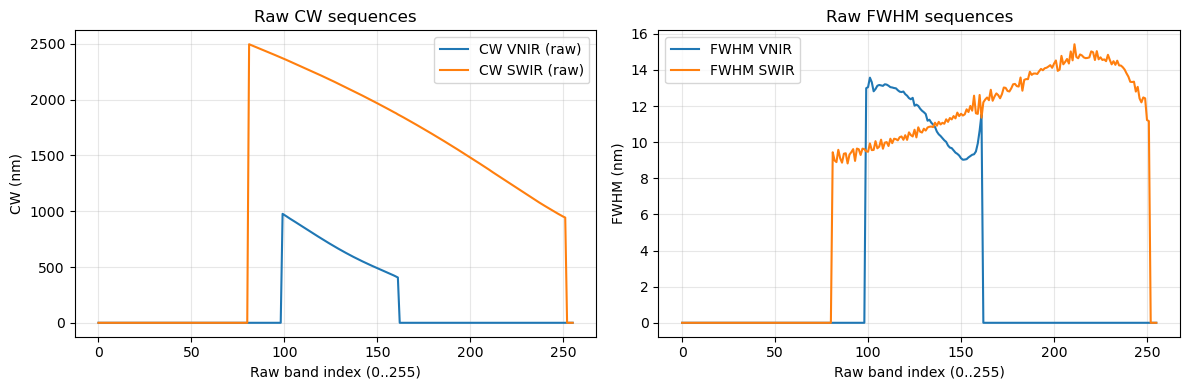

In [13]:

import h5py
import numpy as np
import matplotlib.pyplot as plt

cache_dir = prisma_path.parent
if not Path(resolved_path).exists():
    prisma_path = Path(PRISMA_L1_PATH)
    resolved_path = ensure_resolved_prisma(prisma_path, cache_dir)

with h5py.File(resolved_path, "r") as f:
    cw_vnir_raw = f["KDP_AUX/Cw_Vnir_Matrix"][:]
    cw_swir_raw = f["KDP_AUX/Cw_Swir_Matrix"][:]
    fwhm_vnir_raw = f["KDP_AUX/Fwhm_Vnir_Matrix"][:]
    fwhm_swir_raw = f["KDP_AUX/Fwhm_Swir_Matrix"][:]

nz_vnir = np.nonzero(np.nanmean(cw_vnir_raw, axis=0))[0]
nz_swir = np.nonzero(np.nanmean(cw_swir_raw, axis=0))[0]
print("VNIR raw indices with CW>0:", nz_vnir[0], "→", nz_vnir[-1], "(len", nz_vnir.size, ")")
print("SWIR raw indices with CW>0:", nz_swir[0], "→", nz_swir[-1], "(len", nz_swir.size, ")")

cw_vnir_seq = np.nanmean(cw_vnir_raw, axis=0)
cw_swir_seq = np.nanmean(cw_swir_raw, axis=0)

print("VNIR raw first 5 CWs:", cw_vnir_seq[nz_vnir[:5]])
print("VNIR raw last 5 CWs:", cw_vnir_seq[nz_vnir[-5:]])
print("SWIR raw first 5 CWs:", cw_swir_seq[nz_swir[:5]])
print("SWIR raw last 5 CWs:", cw_swir_seq[nz_swir[-5:]])

vnir_tail = cw_vnir_seq[nz_vnir][-10:]
swir_head = cw_swir_seq[nz_swir][:10]
print("VNIR tail CWs:", vnir_tail)
print("SWIR head CWs:", swir_head)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(cw_vnir_seq, label="CW VNIR (raw)")
ax[0].plot(cw_swir_seq, label="CW SWIR (raw)")
ax[0].set_title("Raw CW sequences")
ax[0].set_xlabel("Raw band index (0..255)")
ax[0].set_ylabel("CW (nm)")
ax[0].legend(); ax[0].grid(alpha=0.3)
ax[1].plot(np.nanmean(fwhm_vnir_raw, axis=0), label="FWHM VNIR")
ax[1].plot(np.nanmean(fwhm_swir_raw, axis=0), label="FWHM SWIR")
ax[1].set_title("Raw FWHM sequences")
ax[1].set_xlabel("Raw band index (0..255)")
ax[1].set_ylabel("FWHM (nm)")
ax[1].legend(); ax[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()



## CW/FWHM raw visualization vs cube dimensions
Visualise the raw CW/FWHM matrices (track × band) and compare their dimensions to the VNIR/SWIR cubes. Rows correspond to along-track samples; columns to spectral bands. We care about across-track variation, so the plots collapse zeros but keep the 2D structure.


VNIR cube shape (rows, cols, bands): (1000, 1000, 66)
SWIR cube shape (rows, cols, bands): (1000, 1000, 173)


CW VNIR raw shape: (1000, 256)
CW SWIR raw shape: (1000, 256)
FWHM VNIR raw shape: (1000, 256)
FWHM SWIR raw shape: (1000, 256)


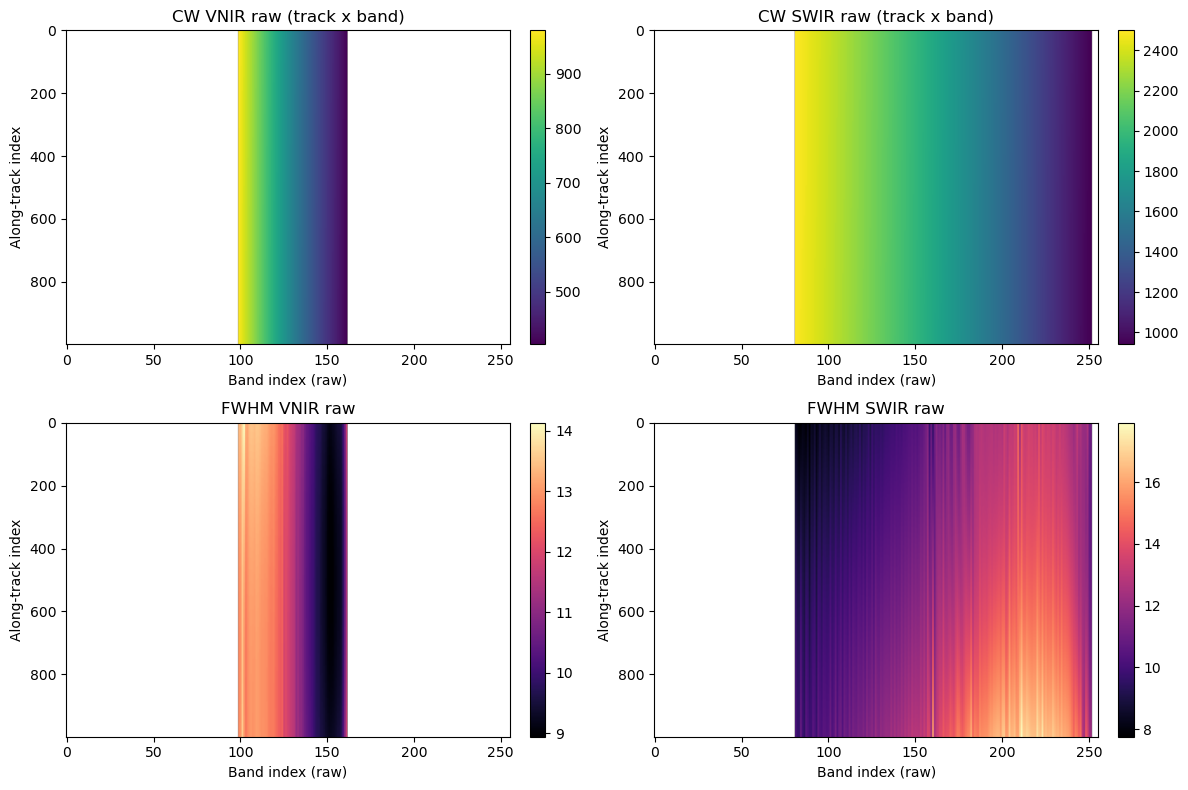

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import h5py

print("VNIR cube shape (rows, cols, bands):", vnir_cube_bip.shape)
print("SWIR cube shape (rows, cols, bands):", swir_cube_bip.shape)

with h5py.File(resolved_path, "r") as f:
    cw_vnir_raw = f["KDP_AUX/Cw_Vnir_Matrix"][:]
    cw_swir_raw = f["KDP_AUX/Cw_Swir_Matrix"][:]
    fwhm_vnir_raw = f["KDP_AUX/Fwhm_Vnir_Matrix"][:]
    fwhm_swir_raw = f["KDP_AUX/Fwhm_Swir_Matrix"][:]

print("CW VNIR raw shape:", cw_vnir_raw.shape)
print("CW SWIR raw shape:", cw_swir_raw.shape)
print("FWHM VNIR raw shape:", fwhm_vnir_raw.shape)
print("FWHM SWIR raw shape:", fwhm_swir_raw.shape)

# Mask zeros to visualize
cw_vnir_masked = np.where(cw_vnir_raw > 0, cw_vnir_raw, np.nan)
cw_swir_masked = np.where(cw_swir_raw > 0, cw_swir_raw, np.nan)
fwhm_vnir_masked = np.where(fwhm_vnir_raw > 0, fwhm_vnir_raw, np.nan)
fwhm_swir_masked = np.where(fwhm_swir_raw > 0, fwhm_swir_raw, np.nan)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
im0 = axes[0,0].imshow(cw_vnir_masked, aspect='auto', cmap='viridis')
axes[0,0].set_title('CW VNIR raw (track x band)'); plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)
im1 = axes[0,1].imshow(cw_swir_masked, aspect='auto', cmap='viridis')
axes[0,1].set_title('CW SWIR raw (track x band)'); plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)
im2 = axes[1,0].imshow(fwhm_vnir_masked, aspect='auto', cmap='magma')
axes[1,0].set_title('FWHM VNIR raw'); plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)
im3 = axes[1,1].imshow(fwhm_swir_masked, aspect='auto', cmap='magma')
axes[1,1].set_title('FWHM SWIR raw'); plt.colorbar(im3, ax=axes[1,1], fraction=0.046, pad=0.04)
for ax in axes.ravel():
    ax.set_xlabel('Band index (raw)')
    ax.set_ylabel('Along-track index')
plt.tight_layout(); plt.show()
